In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns

import numpy as np
import matplotlib.colors as mcolors

### 1. Processing incidents data

Aggregate the incidents data and fire stations into grids with side lengths of 500m and calculate the centroid of each grid.

In [5]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
incidents = incidents.reset_index(drop=True)

In [6]:
stations = pd.read_csv('Data/WMFS_datasets/station_locations.csv')

In [7]:
stations

,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed
0,Aldridge,405203,302818,1,0,N,Before study period,NaN
1,Aston,407316,289711,1,1,N,Before study period,NaN
2,Bickenhill,419627,284038,1,0,N,Before study period,NaN
3,Billesley,409029,281369,1,1,N,Before study period,NaN
4,Bilston,394543,296040,1,0,N,Before study period,NaN
5,Binley,436876,278691,1,1,N,Before study period,NaN
6,Bloxwich,399846,301797,1,0,N,Before study period,NaN
7,Bournbrook,405167,283287,1,0,N,Before study period,NaN
8,Brierley Hill,391862,287775,1,1,N,Before study period,NaN
9,Canley,430542,277280,1,0,N,Before study period,NaN


In [8]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size


In [9]:
# Caculate the grid index of incidents and fire stations
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

stations['grid_x'] = ((stations['Easting'] - xmin) // grid_size).astype(int)
stations['grid_y'] = ((stations['Northing'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)
stations['grid_id'] = stations['grid_x'].astype(str) + "_" + stations['grid_y'].astype(str)

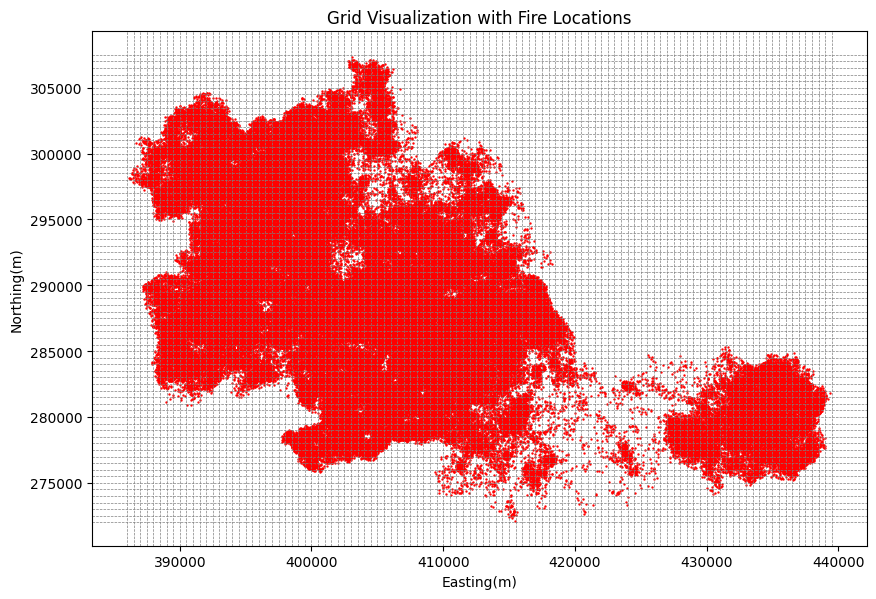

In [10]:
### Visualise the fire incidents

fig, ax = plt.subplots(figsize=(10,7))

# plot the grid cells
for x in range(int(xmin), int(xmax) + grid_size, grid_size):
    ax.axvline(x, color='grey', linestyle='--', lw=0.5)
for y in range(int(ymin), int(ymax) + grid_size, grid_size):
    ax.axhline(y, color='grey', linestyle='--', lw=0.5)

# plot the fire points
ax.scatter(incidents['EASTINGS'], incidents['NORTHINGS'], color='red', s=0.5)
ax.set_aspect('equal')

plt.title('Grid Visualization with Fire Locations')
plt.xlabel('Easting(m)')
plt.ylabel('Northing(m)')
plt.grid(False)  # close default grids
plt.show()

 Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [11]:
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,363


By analyzing the amount of data in each grid and its distribution, we can find much more data in grids are non-normal distributed.

In [12]:
grouped = incidents.groupby('grid_id')

# Create a list for each unique grid id
# It includes grid id, the count of fire, and the normality of the distribution of response time in each grid
distribution = []

for name, group in grouped:
    # Count the fire incidents in each grid
    count = group.shape[0]
    
    # If the incidents are bigger than or equal to 3,
    # Using Shapiro-Wilk for normality test
    if count >= 3:
        stat, p_value = shapiro(group['total_response_time'])
        
        normal = 'Yes' if p_value > 0.05 else 'No'

    else:
        
        normal = 'Insufficient data'
        
    grid_x = group['grid_x'].iloc[0]
    grid_y = group['grid_y'].iloc[0]
    
    distribution.append([name, grid_x, grid_y, count, normal])

grid = pd.DataFrame(distribution, columns=['grid_id', 'grid_x', 'grid_y', 'fire_count', 'is_normal'])


In [13]:
grid['is_normal'].value_counts()

is_normal
No                   2836
Yes                   589
Insufficient data     309
Name: count, dtype: int64

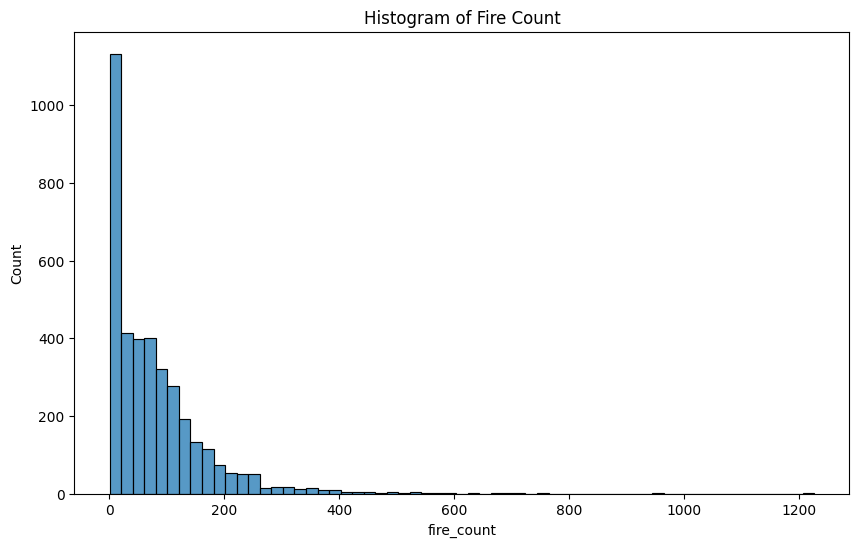

In [14]:
# Histogram of the fire count in grids
count = grid['fire_count']

plt.figure(figsize=(10, 6))
sns.histplot(count, binwidth=20)
plt.title('Histogram of Fire Count')
plt.show()

### 2. Metric selection of fire response time
We have three metrics: **average, median and 90 percentile**, but since the data is not normally distributed, the average metric is eliminated.

In [15]:
metrics = incidents.groupby('grid_id')['total_response_time'].agg(
    median='median',
    percentile_90=lambda x: np.percentile(x, 90)
)

grid = grid.merge(metrics, on='grid_id', how='left')

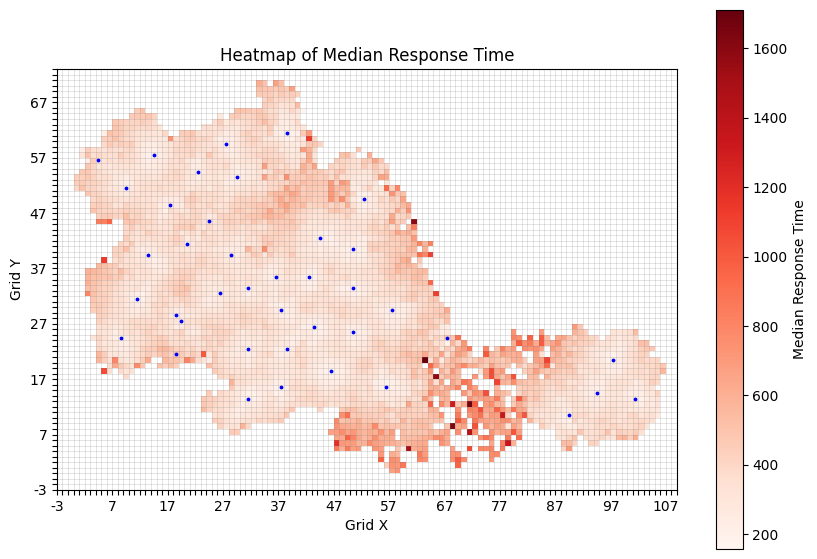

In [16]:
### Visualise the median response time as a heatmap

fig, ax = plt.subplots(figsize=(10, 7))

# set xmin, xmax, ymin and ymax
x_min, x_max = grid['grid_x'].min() - 3, grid['grid_x'].max() + 3
y_min, y_max = grid['grid_y'].min() - 3, grid['grid_y'].max() + 3

# set the ticks
x_ticks = np.arange(x_min, x_max + 1)
y_ticks = np.arange(y_min, y_max + 1)

# plot the grids
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# fill the grid with colour mapped according to the median
norm = mcolors.Normalize(vmin=grid['median'].min(),
                         vmax=grid['median'].max())
cmap = plt.get_cmap('Reds')

for _, row in grid.iterrows():

        color = cmap(norm(row['median']))
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor=color)
        ax.add_patch(rect)

# add the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Median Response Time')

# set axis labels, ranges and title
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.set_title('Heatmap of Median Response Time')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# adjust ticks display frequency
display_freq = 10
ax.set_xticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(x_ticks)])
ax.set_yticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(y_ticks)])

# plot the fire stations
ax.scatter(stations['grid_x'] + 0.5 , stations['grid_y'] + 0.5, color='blue', s=3)

ax.set_aspect('equal')

plt.show()

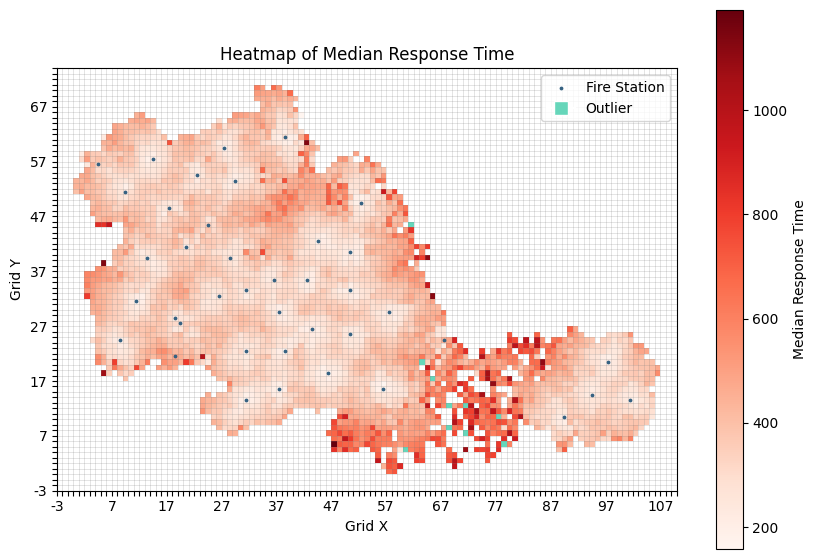

In [17]:
### Visualise the median response time as a heatmap
### Exclude the outliers

import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 7))

# set threshold of the outliers
threshold_m = 1250


# set xmin, xmax, ymin and ymax
x_min, x_max = grid['grid_x'].min() - 3, grid['grid_x'].max() + 4
y_min, y_max = grid['grid_y'].min() - 3, grid['grid_y'].max() + 4

# set the ticks
x_ticks = np.arange(x_min, x_max + 1)
y_ticks = np.arange(y_min, y_max + 1)

# plot the grids
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# fill the grid with colour mapped according to the median
norm = mcolors.Normalize(vmin=grid['median'].min(),
                         vmax=grid['median'][grid['median'] <= threshold_m].max())
cmap = plt.get_cmap('Reds')

for _, row in grid.iterrows():
    if row['median'] <= threshold_m:
        color = cmap(norm(row['median']))
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor=color)
        ax.add_patch(rect)
    else:
        # use a different color to mark outliers
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor='#66D6BA')
        ax.add_patch(rect)


# add the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Median Response Time')

# set axis labels, ranges and title
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.set_title('Heatmap of Median Response Time')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# adjust ticks display frequency
display_freq = 10
ax.set_xticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(x_ticks)])
ax.set_yticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(y_ticks)])

# plot the fire stations
ax.scatter(stations['grid_x'] + 0.5 , stations['grid_y'] + 0.5, color='#366282', s=3, label='Fire Station')

# add legend
handles, labels = ax.get_legend_handles_labels()
outliers_patch = plt.Line2D([0], [0], marker='s', color='w', label='Outlier',
                            markerfacecolor='#66D6BA', markersize=10)

handles.append(outliers_patch)
ax.legend(handles=handles, loc='upper right')


ax.set_aspect('equal')

plt.show()

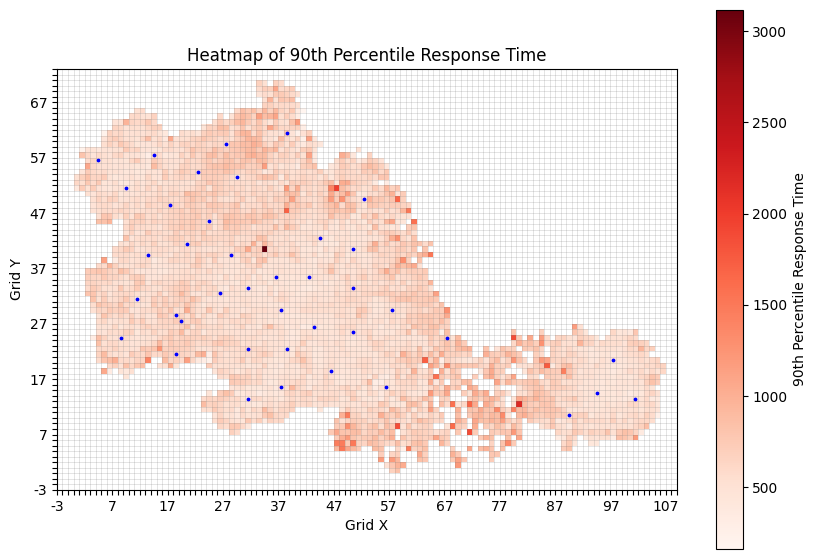

In [18]:
### Visualise the 90th percentile response time as a heatmap

fig, ax = plt.subplots(figsize=(10, 7))

# set xmin, xmax, ymin and ymax
x_min, x_max = grid['grid_x'].min() - 3, grid['grid_x'].max() + 3
y_min, y_max = grid['grid_y'].min() - 3, grid['grid_y'].max() + 3

# set the ticks
x_ticks = np.arange(x_min, x_max + 1)
y_ticks = np.arange(y_min, y_max + 1)

# plot the grids
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# fill the grid with colour mapped according to the median
norm = mcolors.Normalize(vmin=grid['percentile_90'].min(),
                         vmax=grid['percentile_90'].max())
cmap = plt.get_cmap('Reds')

for _, row in grid.iterrows():

        color = cmap(norm(row['percentile_90']))
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor=color)
        ax.add_patch(rect)

# add the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('90th Percentile Response Time')

# set axis labels, ranges and title
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.set_title('Heatmap of 90th Percentile Response Time')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# adjust ticks display frequency
display_freq = 10
ax.set_xticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(x_ticks)])
ax.set_yticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(y_ticks)])

# plot the fire stations
ax.scatter(stations['grid_x'] + 0.5 , stations['grid_y'] + 0.5, color='blue', s=3)

ax.set_aspect('equal')

plt.show()

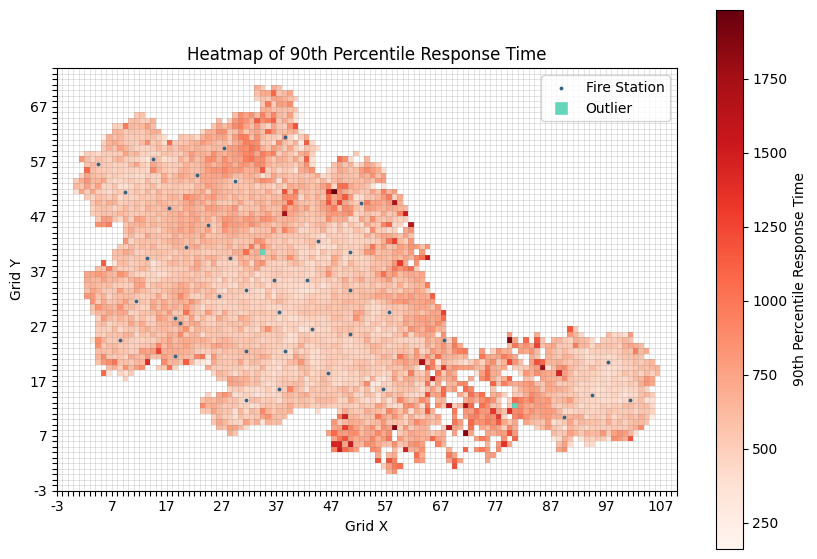

In [19]:
### Visualise the 90th percentile response time as a heatmap
### Exclude the outliers

import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 7))

# set threshold of the outliers
threshold_m = 2000


# set xmin, xmax, ymin and ymax
x_min, x_max = grid['grid_x'].min() - 3, grid['grid_x'].max() + 4
y_min, y_max = grid['grid_y'].min() - 3, grid['grid_y'].max() + 4

# set the ticks
x_ticks = np.arange(x_min, x_max + 1)
y_ticks = np.arange(y_min, y_max + 1)

# plot the grids
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# fill the grid with colour mapped according to the median
norm = mcolors.Normalize(vmin=grid['percentile_90'].min(),
                         vmax=grid['percentile_90'][grid['percentile_90'] <= threshold_m].max())
cmap = plt.get_cmap('Reds')

for _, row in grid.iterrows():
    if row['percentile_90'] <= threshold_m:
        color = cmap(norm(row['percentile_90']))
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor=color)
        ax.add_patch(rect)
    else:
        # use a different color to mark outliers
        rect = plt.Rectangle((row['grid_x'], row['grid_y']), 1, 1, facecolor='#66D6BA')
        ax.add_patch(rect)


# add the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('90th Percentile Response Time')

# set axis labels, ranges and title
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.set_title('Heatmap of 90th Percentile Response Time')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# adjust ticks display frequency
display_freq = 10
ax.set_xticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(x_ticks)])
ax.set_yticklabels([str(int(label)) if i % display_freq == 0 else '' for i, label in enumerate(y_ticks)])

# plot the fire stations
ax.scatter(stations['grid_x'] + 0.5 , stations['grid_y'] + 0.5, color='#366282', s=3, label='Fire Station')

# add legend
handles, labels = ax.get_legend_handles_labels()
outliers_patch = plt.Line2D([0], [0], marker='s', color='w', label='Outlier',
                            markerfacecolor='#66D6BA', markersize=10)

handles.append(outliers_patch)
ax.legend(handles=handles, loc='upper right')

ax.set_aspect('equal')

plt.show()